In [ ]:
pip install torch torchvision

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.6 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib

In [ ]:

from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/pytorch'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['Bayesian.ipynb', 'Dropout.ipynb', 'ResNet.ipynb', '__init__.py', '__pycache__', 'baseline.ipynb', 'data', 'py_code', 'result_auroc_OD.json', 'results_DAC_temp.json', 'results_DAC_temp_swin.json', 'results_Dropout.json', 'results_Dropout_swin.json', 'results_ECE.json', 'results_ECE_OD.json', 'results_ECE_swin.json', 'results_auroc.json', 'swin.ipynb']


In [ ]:
import numpy as np
import os
import json
import random
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd


def fsw_labels_to_csv():
    annotations = []
    src_path = "data/raw/hx_fsw/images/"
    for seam_nr in range(1, 115):
        for ann_file in os.listdir(f"{src_path}{seam_nr}/annotations"):
            tree = ET.parse(f"{src_path}{seam_nr}/annotations/{ann_file}")
            item = {}
            for child in tree.getroot():
                item[child.tag] = child.text
            item["img_path"] = f"{src_path}{seam_nr}/cutouts/"+item["filename"]
            item["seam_nr"] = seam_nr  # This adds the seam_nr value to each annotation item
            item.setdefault('temp_label', None)
            item.setdefault('grat_label', None)
            item.setdefault('inner_label', None)
            annotations.append(item)


    df = pd.DataFrame(annotations)
    df.to_csv("data/raw/hx_fsw/annotations.csv", sep=";")


def fsw_make_annotations():
    def df_to_list(df):
        data = [{"img_path": x.replace("../", ""), "seam_nr": y, "Group": m, "labels": (z1, z2, z3)}
            for x, y, z1, z2, z3 , m in zip(df['img_path'], df["Weld Seam Nr."], df['temp_label'], df['grat_label'], df['inner_label'], df['Group'])]
        return data

    df = pd.read_csv("data/raw/hx_fsw/annotations.csv", sep=";")
    all_data = df_to_list(df)

    # Filter out data from groups 1, 2, and 3 for cross-validation
    filtered_data = [d for d in all_data if d['Group'] in [1, 2, 3]]
    # OD data for model evaluation
    OD_data = [d for d in all_data if d['Group'] in [5,6,7]]

    # Shuffle filtered_data
    random.shuffle(filtered_data)
    random.shuffle(OD_data)
    # Set the number of splits for cross-validation
    num_splits = 5
    split_size = len(filtered_data) // num_splits

    cv_anns = {}

    for split in range(num_splits):
        # Create train, validation, and test splits
        start = split * split_size
        end = start + split_size
        test_data = filtered_data[start:end]

        train_data = filtered_data[:start] + filtered_data[end:]
        train_end = len(train_data) - len(train_data) // 3
        train_data, val_data = train_data[:train_end], train_data[train_end:]

        cv_anns[split + 1] = {
            "train": train_data,
            "val": val_data,
            "test": test_data,
            "ODdata": OD_data[:500]
        }

        print(f"Split {split + 1}: Train = {len(train_data)}, Val = {len(val_data)}, Test = {len(test_data)}, OD = {len(OD_data)}")

    # Write the cross-validation annotations to a file
    with open("data/raw/hx_fsw/cv_annotations.json", "w") as file:
        file.write(json.dumps(cv_anns, indent=4))


In [ ]:
fsw_make_annotations()

Split 1: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 2: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 3: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 4: Train = 1480, Val = 740, Test = 554, OD = 4018
Split 5: Train = 1480, Val = 740, Test = 554, OD = 4018


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image


class FSWDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        """
        Overwrites the methods of the pytorch dataset class and defines
        how to return an image and a label

        Args:
            paths: list with image paths
            labels: list with labels
            transform: None or torchvision transforms to apply to image
        """

        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # load specific sample
        img = Image.open(self.paths[idx])
        label = self.labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        # apply transforms
        if self.transform is not None:
            img = self.transform(img)

        return img, label


class AddNoiseToTensor(object):
    def __init__(self, p, alpha):
        """
        implements the __call__ method of a torchvision transform operation

        Args:
            p: probability with which the transform should be applied
            alpha: scaling factor for the normal distributed noise
        """
        self.p = p
        self.a = alpha

    def __call__(self, x):

        # tip: use pytorch for random operations, since it handles management of random seeds in
        # workers of dataloader correctly. Numpy for example doesn't, which results in identical samples
        if torch.rand(1) < self.p:
            # add noise from normal distribution to tensor with a given probability
            return x + torch.randn_like(x) * self.a
        return x


class AdjustBrightnessOfTensor(object):
    def __init__(self, p, alpha):
        """
        implements the __call__ method of a torchvision transform operation

        Args:
            p: probability with which the transform should be applied
            alpha: scaling factor for the uniform distributed noise
        """
        self.p = p
        self.a = alpha

    def __call__(self, x):
        if torch.rand(1) < self.p:
            # add brightness value from uniform distribution to tensor with a given probability
            x = x + (torch.rand(1) - 0.5) * self.a
            x = torch.where(x < 1., x, 1.)
            x = torch.where(x > 0., x, 0.)
        return x


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
for cv_i in [str(x) for x in range(1, 5)]:
    # get paths and labels
    label_i = 1  # (grat)
    num_classes = 2  # (grat)
    with open(f"data/raw/hx_fsw/cv_annotations.json") as file:
        data = json.load(file)

    vl_paths = [sample["img_path"] for sample in data[cv_i]["val"]]
    vl_labels = [sample["labels"][label_i] for sample in data[cv_i]["val"]]
    ts_paths = [sample["img_path"] for sample in data[cv_i]["test"]]
    ts_labels = [sample["labels"][label_i] for sample in data[cv_i]["test"]]
    tr_paths = [sample["img_path"] for sample in data[cv_i]["train"]]
    tr_labels = [sample["labels"][label_i] for sample in data[cv_i]["train"]]

    # prep for the OD data
    OD_paths = [sample["img_path"] for sample in data[cv_i]["ODdata"]]
    OD_labels = [sample["labels"][label_i] for sample in data[cv_i]["ODdata"]]




tr_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Add this line
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddNoiseToTensor(p=0.5, alpha=0.1),
])

vl_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Add this line
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# build datasets and dataloaders
train_dataset = FSWDataset(paths=tr_paths, labels=tr_labels, transform=tr_transform)
test_dataset = FSWDataset(paths=ts_paths, labels=ts_labels, transform=vl_transform)
val_dataset = FSWDataset(paths=vl_paths, labels=vl_labels, transform=vl_transform)
OD_dataset = FSWDataset(paths=OD_paths, labels=OD_labels, transform=vl_transform)

# Model loading and overriding
The last fully connected layer of the original model is replaced with a new one containing a dropout layer (for regularization) followed by a linear layer for a binary classification task.
The forward method of this class is overridden to modify the standard forward pass of the ResNet model. Here, the model processes the input through all its layers up to the average pooling layer. The output tensor is then flattened to obtain feature representations (features), and these features are further processed by the fully connected layer (self.fc) to obtain the final output.
The model now returns both the final output and the features.
An instance of the ModifiedResNet model is created using ResNet50's configuration (i.e., using the Bottleneck block and [3, 4, 6, 3] layers, which corresponds to ResNet50). The number of output classes is set to 2, which indicates binary classification.
Again, as with the initial ResNet50 model, the final fully connected layer is replaced with a dropout layer followed by a linear layer

In [ ]:
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import random

# Add a Dropout layer followed by the final Linear layer
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader= DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
OD_loader= DataLoader(OD_dataset, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
class ModifiedResNet(models.resnet.ResNet):
    def forward(self, x):
        # Original forward pass up to the penultimate layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        features = torch.flatten(x, 1)  # This will be the feature tensor

        # Final fully connected layer
        x = self.fc(features)

        return x, features

In [ ]:
model = ModifiedResNet(models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=2)  # This initialization is for ResNet50, 2 for training for grat for now
# Add Dropout and Final Linear Layer to the model's fc
num_classes = 2
model.fc = nn.Sequential(
    nn.Dropout(0.5), # 50% dropout rate
    nn.Linear(model.fc.in_features, num_classes)
)

# If you want to initialize with pretrained weights:
state_dict = models.resnet50(pretrained=True).state_dict()
del state_dict["fc.weight"]
del state_dict["fc.bias"]
model.load_state_dict(state_dict, strict=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


_IncompatibleKeys(missing_keys=['fc.1.weight', 'fc.1.bias'], unexpected_keys=[])

This new class aims to modify the provided original_model (in this case, a ResNet model) to not only return the final output (class probabilities) but also the feature representations from the layer before the final fully connected (FC) layer.

The feature extraction part (named self.features) is created by taking all layers from the original_model except the last one (the final FC layer). This is achieved using the list(original_model.children())[:-1] command. The purpose is to get the feature maps before they are flattened and passed through the final FC layer.
The final FC layer (self.fc) is separately stored, as it will be used to produce the final output.

The forward method takes an input tensor x and passes it through the feature extraction layers.
These feature maps are then flattened and passed through the final FC layer to get the model's output.
The function returns both the final output and the feature maps, providing dual functionality: standard prediction and feature extraction.


In [ ]:
#DAC
# this is the feature absatrction for only ResNet
from sklearn.neighbors import NearestNeighbors
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#extracting features from model layers (slight modification for the model required)
model = model.to(device)
class FeatureExtractorModel(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractorModel, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Removing last FC layer
        self.fc = original_model.fc

    def forward(self, x):
        features = self.features(x)
        output = self.fc(features.view(features.size(0), -1))
        return output, features

model = FeatureExtractorModel(model)

In [ ]:
pip install tqdm tensorboard

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm  # for a nice progress bar
import matplotlib.pyplot as plt


train_losses = []
val_accuracies = []

# Parameters
num_epochs = 70
learning_rate = 1e-6

# Using CUDA if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):

        inputs, labels = inputs.to(device), labels.to(device)

        # Getting outputs and features
        outputs, features = model(inputs)
        # Use the outputs for loss calculation
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}")


    # Validation
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, features = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")

print("Finished Training")

  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 1/70] Loss: 0.7475
Validation Accuracy: 48.38%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 2/70] Loss: 0.7020
Validation Accuracy: 58.92%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 3/70] Loss: 0.6899
Validation Accuracy: 66.49%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 4/70] Loss: 0.6400
Validation Accuracy: 70.54%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 5/70] Loss: 0.6059
Validation Accuracy: 75.14%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 6/70] Loss: 0.5968
Validation Accuracy: 78.51%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 7/70] Loss: 0.5649
Validation Accuracy: 80.27%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 8/70] Loss: 0.5430
Validation Accuracy: 82.16%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 9/70] Loss: 0.5208
Validation Accuracy: 82.97%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 10/70] Loss: 0.5103
Validation Accuracy: 84.32%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 11/70] Loss: 0.5145
Validation Accuracy: 84.59%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 12/70] Loss: 0.4708
Validation Accuracy: 84.86%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 13/70] Loss: 0.4552
Validation Accuracy: 85.81%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 14/70] Loss: 0.4539
Validation Accuracy: 87.03%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 15/70] Loss: 0.4303
Validation Accuracy: 87.16%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 16/70] Loss: 0.4108
Validation Accuracy: 87.70%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 17/70] Loss: 0.3997
Validation Accuracy: 88.24%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 18/70] Loss: 0.3963
Validation Accuracy: 89.46%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 19/70] Loss: 0.3658
Validation Accuracy: 89.59%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 20/70] Loss: 0.3748
Validation Accuracy: 89.59%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 21/70] Loss: 0.3510
Validation Accuracy: 89.73%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 22/70] Loss: 0.3465
Validation Accuracy: 90.81%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 23/70] Loss: 0.3487
Validation Accuracy: 90.41%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 24/70] Loss: 0.3208
Validation Accuracy: 90.54%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 25/70] Loss: 0.2978
Validation Accuracy: 91.08%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 26/70] Loss: 0.3019
Validation Accuracy: 91.76%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 27/70] Loss: 0.2973
Validation Accuracy: 91.89%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 28/70] Loss: 0.2735
Validation Accuracy: 92.03%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 29/70] Loss: 0.2712
Validation Accuracy: 92.57%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 30/70] Loss: 0.2657
Validation Accuracy: 92.57%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 31/70] Loss: 0.2713
Validation Accuracy: 92.84%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 32/70] Loss: 0.2606
Validation Accuracy: 92.43%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 33/70] Loss: 0.2473
Validation Accuracy: 93.24%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 34/70] Loss: 0.2371
Validation Accuracy: 93.51%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 35/70] Loss: 0.2392
Validation Accuracy: 93.65%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 36/70] Loss: 0.2271
Validation Accuracy: 93.11%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 37/70] Loss: 0.2101
Validation Accuracy: 93.78%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 38/70] Loss: 0.2067
Validation Accuracy: 93.78%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 39/70] Loss: 0.2100
Validation Accuracy: 94.59%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 40/70] Loss: 0.1944
Validation Accuracy: 94.86%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 41/70] Loss: 0.1899
Validation Accuracy: 94.86%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 42/70] Loss: 0.1802
Validation Accuracy: 95.00%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 43/70] Loss: 0.1799
Validation Accuracy: 95.14%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 44/70] Loss: 0.1663
Validation Accuracy: 95.54%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 45/70] Loss: 0.1839
Validation Accuracy: 95.27%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 46/70] Loss: 0.1736
Validation Accuracy: 95.27%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 47/70] Loss: 0.1736
Validation Accuracy: 95.41%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 48/70] Loss: 0.1553
Validation Accuracy: 96.22%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 49/70] Loss: 0.1539
Validation Accuracy: 95.95%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 50/70] Loss: 0.1393
Validation Accuracy: 96.35%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 51/70] Loss: 0.1513
Validation Accuracy: 96.49%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 52/70] Loss: 0.1328
Validation Accuracy: 96.76%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 53/70] Loss: 0.1325
Validation Accuracy: 96.89%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 54/70] Loss: 0.1315
Validation Accuracy: 96.62%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 55/70] Loss: 0.1235
Validation Accuracy: 97.03%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 56/70] Loss: 0.1220
Validation Accuracy: 97.16%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 57/70] Loss: 0.1331
Validation Accuracy: 97.43%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 58/70] Loss: 0.1035
Validation Accuracy: 97.30%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 59/70] Loss: 0.1096
Validation Accuracy: 97.57%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 60/70] Loss: 0.1136
Validation Accuracy: 97.30%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 61/70] Loss: 0.1060
Validation Accuracy: 97.57%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 62/70] Loss: 0.1034
Validation Accuracy: 97.57%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 63/70] Loss: 0.1035
Validation Accuracy: 97.70%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 64/70] Loss: 0.0934
Validation Accuracy: 97.84%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 65/70] Loss: 0.0959
Validation Accuracy: 97.70%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 66/70] Loss: 0.0947
Validation Accuracy: 97.84%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 67/70] Loss: 0.0852
Validation Accuracy: 97.97%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 68/70] Loss: 0.0899
Validation Accuracy: 97.84%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 69/70] Loss: 0.0861
Validation Accuracy: 97.70%


  0%|          | 0/24 [00:00<?, ?it/s]

[Epoch 70/70] Loss: 0.0767
Validation Accuracy: 97.84%
Finished Training


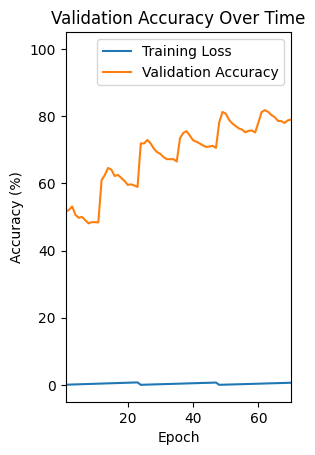

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Time')
plt.legend()
plt.xlim(1, num_epochs)  # Set x-axis limits

plt.show()


In [ ]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, features = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model,test_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 97.47%
Average Test Loss: 0.0868


In [ ]:
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # We'll also keep track of the loss for the test dataset
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, features = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)  # Predicted class is the max index across the softmax probabilities
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    return accuracy, avg_test_loss

# To use the evaluate function:
accuracy, avg_loss = evaluate(model, OD_loader, device) # change the data here to experience concept drift
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Average Test Loss: {avg_loss:.4f}")

Test Accuracy: 85.60%
Average Test Loss: 0.3399


In [ ]:
def extract_features(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    feature_list = []

    with torch.no_grad():
        for inputs, _ in dataloader:  # we don't need labels for this
            inputs = inputs.to(device)
            _, features = model(inputs)
            features = features.view(features.size(0), -1).cpu().detach().numpy()
            feature_list.append(features)

    return np.vstack(feature_list)

# Extract all features from training data
train_features_all = extract_features(model, train_loader, device)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
# Calculate density estimates(can be extended to multiple layers)
w = torch.tensor([1.0], requires_grad=True, device=device)
w0 = torch.tensor([1.0], requires_grad=True, device=device)
# w, w0: Learned parameters for adjusting the logits based on density.


def compute_density_estimates(train_features, test_features, k=50):
    # Convert train_features to numpy if they are tensors
    train_features = train_features.cpu().numpy() if isinstance(train_features, torch.Tensor) else train_features
    test_features = test_features.cpu().numpy() if isinstance(test_features, torch.Tensor) else test_features

    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(train_features)
    distances, _ = nn.kneighbors(test_features)
    return distances[:, -1]

def adjust_logits_with_density(logits, densities, w, w0):
    # Ensure densities are a 2D tensor with shape [batch_size, 1]
    densities = densities[:, None] if densities.ndim == 1 else densities
    # Compute scaling factor S with shape [batch_size, 1]
    S = densities * w + w0
    # Adjust logits - this should now broadcast correctly
    adjusted_logits = logits / S
    return adjusted_logits


def squared_loss(logits_adjusted, labels):
    Ic = torch.nn.functional.one_hot(labels, num_classes=logits_adjusted.shape[1])
    probs = torch.nn.functional.softmax(logits_adjusted, dim=1)
    loss = ((Ic.to(device) - probs) ** 2).sum()  # Move Ic tensor to the same device as probs
    return loss

# Optimization of the weights w and bias w0 on a validation set
def optimize_weights_bias(model, val_loader, device, epochs=20, lr=1e-6): # epoch here should be at least 10(maybe even up to 50 but I stopped it since it takes forever to train), but bear in mind it takes forever to calibrate
    optimizer = optim.SGD([w, w0], lr=lr) # stochastic optimization for the bias and weights
    for epoch in range(epochs):
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, val_features = model(inputs)
            val_features = val_features.view(val_features.size(0), -1).cpu().detach().numpy()
            densities = compute_density_estimates(train_features_all, val_features)
            densities = torch.tensor(densities, dtype=torch.float32, device=device)  # Convert numpy array to tensor
            logits_adjusted = adjust_logits_with_density(outputs, densities, w, w0)  # Avoid detaching outputs to CPU
            loss = squared_loss(logits_adjusted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
import torch.optim as optim

# Define Temperature Scaling Module
class TemperatureScaling:
    def __init__(self, model, initial_temp=1.0, device='cpu'):
        self.model = model
        self.model.eval()  # Set the model to evaluation mode
        self.device = device
        self.temperature = torch.nn.Parameter(torch.ones(1, device=self.device) * initial_temp)

    def nll_loss(self, logits, labels): #negative log likelihood losss
        return torch.nn.functional.cross_entropy(logits, labels)

    def optimize_temperature(self, val_loader, lr=1e-6, epochs=20):  # optimal number of epoch is way more than this but calibration takes forever
        optimizer = optim.LBFGS([self.temperature], lr=lr) # LBFGS optimization for the termperature scaling
        def closure():
            optimizer.zero_grad()
            loss_total = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                with torch.no_grad():
                    outputs, _ = self.model(inputs)
                scaled_logits = outputs / self.temperature
                loss = self.nll_loss(scaled_logits, labels)
                loss_total += loss.item()
                loss.backward()
            return loss

        # Run the optimization loop
        for epoch in range(epochs):
            optimizer.step(closure)

    def scale(self, logits):
        return logits / self.temperature.detach()

def calibrate_and_evaluate(model, val_loader, test_loader, device, num_forward_passes=10):
    # Optimize w and w0 using the DAC method
    model.to(device)
    optimize_weights_bias(model, val_loader, device)

    # Initialize temperature scaling with the current model
    temp_scaling = TemperatureScaling(model, device=device)
    # Optimize the temperature with the validation set
    temp_scaling.optimize_temperature(val_loader)

    correct = 0
    total = 0

    # Perform DAC and temperature scaling calibration
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)  # Ensure labels are on the same device as predictions
            outputs_list = []
            features_list = []  # List to store features for each forward pass

            for _ in range(num_forward_passes):
                outputs, features = model(inputs)
                outputs_list.append(outputs)
                features_list.append(features.view(features.size(0), -1))  # Flatten features here

            # Average the outputs and features from all forward passes
            outputs_mean = torch.mean(torch.stack(outputs_list), dim=0)
            features_mean = torch.mean(torch.stack(features_list), dim=0)  # Average the features

            # Assuming train_features_all and test_features are NumPy arrays
            # You should compute density estimates outside this loop and pass them to this function
            densities = compute_density_estimates(train_features_all, features_mean.cpu().numpy())  # Now this should be a 2D array
            densities_tensor = torch.from_numpy(densities).float().to(device)

            logits_adjusted_dac = adjust_logits_with_density(outputs_mean, densities_tensor, w, w0)
            logits_adjusted_temp = temp_scaling.scale(logits_adjusted_dac)

            _, predicted_adjusted = torch.max(logits_adjusted_temp, 1)
            total += labels.size(0)
            correct += (predicted_adjusted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Call the function to calibrate and evaluate
accuracy = calibrate_and_evaluate(model, val_loader, test_loader, device)
print(f"Accuracy after DAC and temperature scaling on test dataset: {accuracy * 100:.2f}%")


Accuracy after DAC and temperature scaling on test dataset: 97.47%


In [ ]:
# Sample test result and current datetime
import json
from datetime import datetime
test_result_DAC_temp = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "test_accuracy": accuracy  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_DAC_temp.json', 'a') as file:
    file.write(json.dumps(test_result_DAC_temp) + '\n')

In [ ]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
# initialization for porbs and truelabels
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Extract the actual predictions from the tuple
        actual_outputs = outputs[0]
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.0383


In [ ]:
# Sample test result and current datetime
result_ece = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE.json', 'a') as file:
    file.write(json.dumps(result_ece) + '\n')


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities (assuming binary classification)
        probs = F.softmax(logits, dim=1)[:, 1]

        # Get predictions
        preds = probs > 0.5

        # Store probabilities and correctness
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Calculate AUROC
auroc = roc_auc_score(correctness, predicted_probs)
print(f"AUROC: {auroc:.4f}")


AUROC: 0.9977


In [ ]:
# Sample test result and current datetime
result_auroc = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_auroc.json', 'a') as file:
    file.write(json.dumps(result_auroc) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD

The Above code are all for the ID dada,
Below are for the OD data for calculating the ECE for data with concept drift

In [ ]:
import torch.nn.functional as F
def compute_ece(probs, labels, n_bins=10):
    """
    Compute the Expected Calibration Error (ECE).

    Args:
        probs: Tensor of predicted probabilities of shape [N, C] where C is number of classes.
        labels: Tensor of true labels of shape [N].
        n_bins: Number of bins to use for ECE computation.

    Returns:
        ece: Expected Calibration Error.
    """

    # Get the predicted confidence values (maximum predicted probability)
    confidences, predictions = probs.max(1)

    # Initialize lists to store true positive counts and total count for each bin
    bin_true_positives = [0 for _ in range(n_bins)]
    bin_total = [0 for _ in range(n_bins)]

    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_idx in range(n_bins):
        # Indices of items in the current bin
        bin_indices = (confidences > bin_lowers[bin_idx]) & (confidences <= bin_uppers[bin_idx])

        bin_true_positives[bin_idx] += (predictions[bin_indices] == labels[bin_indices]).float().sum().item()
        bin_total[bin_idx] += bin_indices.float().sum().item()

    # Compute bin accuracies and average confidences
    bin_accuracies = [bin_true_positives[i] / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]
    bin_avg_confidences = [torch.sum(confidences[(confidences > bin_lowers[i]) & (confidences <= bin_uppers[i])]).item() / bin_total[i] if bin_total[i] > 0 else 0 for i in range(n_bins)]

    ece = sum([bin_total[i] / float(probs.size(0)) * abs(bin_avg_confidences[i] - bin_accuracies[i]) for i in range(n_bins)])

    return ece

# After your training/testing loops
probs = torch.tensor([]).to(device)
true_labels = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # Extract the actual predictions from the tuple
        actual_outputs = outputs[0]
        output_probs = F.softmax(actual_outputs, dim=1)
        probs = torch.cat([probs, output_probs], dim=0)
        true_labels = torch.cat([true_labels, labels], dim=0)

ece_od = compute_ece(probs, true_labels)
print(f"Expected Calibration Error (ECE): {ece_od:.4f}")


Expected Calibration Error (ECE): 0.0235


In [ ]:
# Sample test result and current datetime
result_ece_od = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "ECE": ece_od  # Example accuracy value
}

# Saving the result to 'results.json'
with open('results_ECE_OD.json', 'a') as file:
    file.write(json.dumps(result_ece_od) + '\n')

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

model.eval()
correctness = []
predicted_probs = []

with torch.no_grad():
    for inputs, labels in OD_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Extract the actual output logits from the tuple
        logits = outputs[0] if isinstance(outputs, tuple) else outputs

        # Get probabilities (assuming binary classification)
        probs = F.softmax(logits, dim=1)[:, 1]

        # Get predictions
        preds = probs > 0.5

        # Store probabilities and correctness
        predicted_probs.extend(probs.cpu().numpy())
        correctness.extend(labels.cpu().numpy())

# Calculate AUROC
auroc_OD = roc_auc_score(correctness, predicted_probs)
print(f"AUROC: {auroc:.4f}")


AUROC: 0.9977


In [ ]:
# Sample test result and current datetime
result_auroc_OD = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "auroc": auroc_OD  # Example accuracy value
}

# Saving the result to 'results.json'
with open('result_auroc_OD.json', 'a') as file:
    file.write(json.dumps(result_auroc_OD) + '\n')
    # bear in mind that the above 2 code blocks are for the ID acc and ECE, the below blocks are for the OD